In [27]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import HistGradientBoostingRegressor


In [29]:
MASTER_PATH = 'master_dataset.csv'
SAMPLE_SUB_PATHS = ['sample_submission_afcs2025.csv', 'sample_submission.csv']


In [31]:
# ---------- Load data ----------
df = pd.read_csv(MASTER_PATH, parse_dates=['date'])
df = df.sort_values(['id', 'date']).reset_index(drop=True)

# Find sample submission file
sample_path = None
for p in SAMPLE_SUB_PATHS:
    try:
        _ = pd.read_csv(p, nrows=5)
        sample_path = p
        break
    except FileNotFoundError:
        pass
if sample_path is None:
    raise FileNotFoundError('Could not find sample submission file. Put sample_submission_afcs2025.csv (or sample_submission.csv) next to this notebook.')

sample_sub = pd.read_csv(sample_path)

print('Master shape:', df.shape)
print('Submission rows:', sample_sub.shape)
print('Date range:', df['date'].min(), '->', df['date'].max())
print('Num series:', df['id'].nunique())


Master shape: (1620487, 23)
Submission rows: (823, 29)
Date range: 2011-01-29 00:00:00 -> 2016-06-19 00:00:00
Num series: 823


In [32]:
# ---------- Basic cleanup / required columns ----------
required = {'id','date','sales'}
missing = required - set(df.columns)
if missing:
    raise ValueError(f'Master dataset missing required columns: {missing}')

# Ensure numeric
df['sales'] = pd.to_numeric(df['sales'], errors='coerce')
if 'sell_price' in df.columns:
    df['sell_price'] = pd.to_numeric(df['sell_price'], errors='coerce')

# Lightweight event/SNAP flags if present
event_cols = [c for c in df.columns if c.startswith('event_name')]
snap_cols = [c for c in df.columns if c.startswith('snap_')]
if event_cols:
    df['is_event'] = df[event_cols].notna().any(axis=1).astype('int8')
else:
    df['is_event'] = 0
if snap_cols:
    df['is_snap'] = df[snap_cols].eq(1).any(axis=1).astype('int8')
else:
    df['is_snap'] = 0

# Time features
df['weekday'] = df['date'].dt.weekday.astype('int8')  # 0=Mon
df['month'] = df['date'].dt.month.astype('int8')
df['weekofyear'] = df['date'].dt.isocalendar().week.astype('int16')


In [165]:
## Helper functions

def add_lag_roll_features(frame: pd.DataFrame, group_key='id') -> pd.DataFrame:
    """Add lag and rolling features for a frame that contains columns: id, date, sales."""
    frame = frame.sort_values([group_key, 'date']).copy()
    g = frame.groupby(group_key)

    # Lags
    for lag in [1, 7, 14, 28]:
        frame[f'lag_{lag}'] = g['sales'].shift(lag)

    # Rolling means of lag_1 (avoids peeking at current day)
    frame['roll7_mean'] = g['sales'].shift(1).rolling(7).mean().reset_index(level=0, drop=True)
    frame['roll28_mean'] = g['sales'].shift(1).rolling(28).mean().reset_index(level=0, drop=True)

    # Price features (optional)
    if 'sell_price' in frame.columns:
        frame['price_lag_1'] = g['sell_price'].shift(1)
        frame['price_change_1'] = frame['sell_price'] - frame['price_lag_1']
        frame['price_change_7'] = g['sell_price'].pct_change(7)
        frame['price_change_28'] = g['sell_price'].pct_change(28)

    # Calender events
    frame['weekday'] = frame['date'].dt.weekday
    frame['month'] = frame['date'].dt.month
    frame['weekofyear'] = frame['date'].dt.isocalendar().week.astype(int)

    # Christmas feature
    frame['is_christmas'] = ((frame['date'].dt.month == 12) & frame['date'].dt.day.between(20,31)).astype(int)

    # Black Friday feature
    black_friday_dates = pd.to_datetime([
        '2011-11-25','2012-11-23','2013-11-29','2014-11-28',
        '2015-11-27','2016-11-25'
    ])
    frame['is_black_friday'] = frame['date'].isin(black_friday_dates).astype(int)
    
    return frame


def seasonal_naive_7day_forecast(hist: pd.DataFrame, start_date: pd.Timestamp, horizon=28) -> pd.DataFrame:
    """Forecast by copying sales from 7 days ago. Returns columns: id, date, yhat."""
    # Create a complete panel for the forecast dates
    future_dates = pd.date_range(start=start_date, periods=horizon, freq='D')
    ids = hist['id'].unique()
    future = pd.MultiIndex.from_product([ids, future_dates], names=['id','date']).to_frame(index=False)

    # Merge in lagged actuals (7 days back)
    lag_source = hist[['id','date','sales']].copy()
    lag_source['date'] = lag_source['date'] + pd.Timedelta(days=7)
    lag_source = lag_source.rename(columns={'sales':'yhat'})

    out = future.merge(lag_source, on=['id','date'], how='left')

    # Fallback: if missing (e.g., not enough history), use last observed sales
    last_sales = hist.sort_values('date').groupby('id')['sales'].last().rename('last_sales')
    out = out.merge(last_sales, on='id', how='left')
    out['yhat'] = out['yhat'].fillna(out['last_sales'])
    out = out.drop(columns=['last_sales'])
    return out

import pandas as pd
from statsmodels.tsa.holtwinters import ExponentialSmoothing

def ets_weekly_forecast_safe(hist, horizon=28):
    forecasts = []

    for id_, df_id in hist.groupby('id'):
        df_id = df_id.sort_values('date').copy()
        
        # Minimaal aantal dagen checken
        if len(df_id) < 14:
            print(f"Skipping id {id_}: not enough data")
            continue
        
        # Zorg dat 'sales' float is
        df_id['sales'] = df_id['sales'].astype(float)
        
        # Maak volledige daily index
        full_idx = pd.date_range(start=df_id['date'].min(), end=df_id['date'].max(), freq='D')
        y = df_id.set_index('date')['sales'].reindex(full_idx, fill_value=0)
        
        # Check lengte na reindex
        if len(y) < 14:
            print(f"Skipping id {id_}: too short after reindex")
            continue
        
        # Fit ETS
        try:
            model = ExponentialSmoothing(
                y.values,  # GEEN pandas Series, alleen numpy array
                trend='add',
                seasonal='add',
                seasonal_periods=7
            )
            fit = model.fit(optimized=True)
            yhat = fit.forecast(horizon)
            
            fc_df = pd.DataFrame({
                'id': id_,
                'date': pd.date_range(start=y.index[-1]+pd.Timedelta(days=1), periods=horizon, freq='D'),
                'yhat': yhat
            })
            forecasts.append(fc_df)
        except Exception as e:
            print(f"Skipping id {id_} due to error: {e}")
            continue

    if forecasts:
        return pd.concat(forecasts, ignore_index=True)
    else:
        return pd.DataFrame(columns=['id', 'date', 'yhat'])

In [167]:
# split dataset
df_selected = df[['id','date','sales','dataset','sell_price','weekday','month','event_name_1','event_type_1','snap_TX']]

train_df = df_selected[df_selected["dataset"] == "train_validation"]
test_df = df_selected[df_selected["dataset"] == "test_validation"]
eval_df = df_selected[df_selected["dataset"] == "test_evaluation"]

In [23]:
# Use the last 28 days of *available observed sales* per series as validation.

obs = df.dropna(subset=['sales']).copy()

# Global cutoff based on the max observed date (works for single-store or multi-store)
max_obs_date = obs['date'].max()
val_start = max_obs_date - pd.Timedelta(days=27)

train_df = obs[obs['date'] < val_start].copy()
val_df = obs[obs['date'] >= val_start].copy()

print('Max observed date:', max_obs_date)
print('Validation start:', val_start)
print('Train rows:', train_df.shape, ' Val rows:', val_df.shape)


Max observed date: 2016-06-19 00:00:00
Validation start: 2016-05-23 00:00:00
Train rows: (1597443, 26)  Val rows: (23044, 26)


In [127]:
## 2) Seasonal naïve baseline

# Forecast validation horizon (28 days) using only training history
sn_pred = seasonal_naive_7day_forecast(train_df[['id','date','sales']], start_date=val_start, horizon=28)

# Join actuals for the same dates
val_actual = eval_df[['id','date','sales']].rename(columns={'sales':'y'})
sn_eval = sn_pred.merge(val_actual, on=['id','date'], how='inner')
sn_mae = mean_absolute_error(sn_eval['y'], sn_eval['yhat'])
sn_rmse = mean_squared_error(sn_eval['y'], sn_eval['yhat'])
print(f'Seasonal Naive (7-day) | MAE: {sn_mae:.4f}  RMSE: {sn_rmse:.4f}')

Seasonal Naive (7-day) | MAE: 2.0896  RMSE: 24.9826


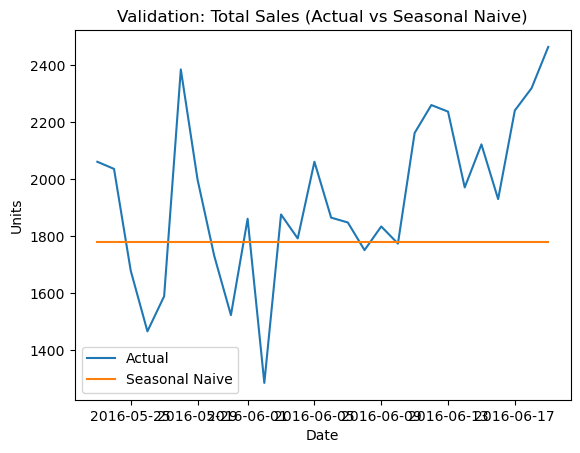

In [131]:
# Quick plot: total actual vs predicted on validation window
sn_plot = sn_eval.groupby('date')[['y','yhat']].sum().reset_index()
plt.figure()
plt.plot(sn_plot['date'], sn_plot['y'], label='Actual')
plt.plot(sn_plot['date'], sn_plot['yhat'], label='Seasonal Naive')
plt.title('Validation: Total Sales (Actual vs Seasonal Naive)')
plt.xlabel('Date')
plt.ylabel('Units')
plt.legend()
plt.show()

In [173]:
## 3) Global ML regressor (lag/rolling + calendar/price)

# Build features on observed data
feat_df = add_lag_roll_features(obs)

# Feature columns
feature_cols = [
    'weekday','month','weekofyear','is_event','is_snap',
    'lag_1','lag_7','lag_14','lag_28','roll7_mean','roll28_mean','is_christmas','is_black_friday','price_lag_1',
    'price_change_1','price_change_7','price_change_28'
]
if 'sell_price' in feat_df.columns:
    feature_cols += ['sell_price','price_change_1']

# Drop rows where we don't have enough lag history
model_df = feat_df.dropna(subset=['sales'] + [c for c in feature_cols if c.startswith('lag_') or c.startswith('roll')]).copy()

# Split dataset
train_df = model_df[model_df['dataset']=='train_validation']
train_df = train_df.drop(columns=['dataset'])

eval_df = model_df[model_df['dataset']=='test_validation']
eval_df = eval_df.drop(columns=['dataset'])

X_train, y_train = train_df[feature_cols], train_df['sales']
X_val, y_val = eval_df[feature_cols], eval_df['sales']

print('Train ML rows:', X_train.shape, ' Val ML rows:', X_val.shape)


Train ML rows: (1551355, 19)  Val ML rows: (23044, 19)


In [177]:
# Train regressor
ml = HistGradientBoostingRegressor(
    loss='squared_error',
    max_depth=8,
    learning_rate=0.08,
    max_iter=250,
    random_state=42
)
ml.fit(X_train, y_train)

val_pred = ml.predict(X_val)
val_pred = np.clip(val_pred, 0, None)  # sales can't be negative

mae = mean_absolute_error(y_val, val_pred)
rmse = mean_squared_error(y_val, val_pred)
print(f'Global ML | MAE: {mae:.4f}  RMSE: {rmse:.4f}')


Global ML | MAE: 1.3055  RMSE: 6.6784


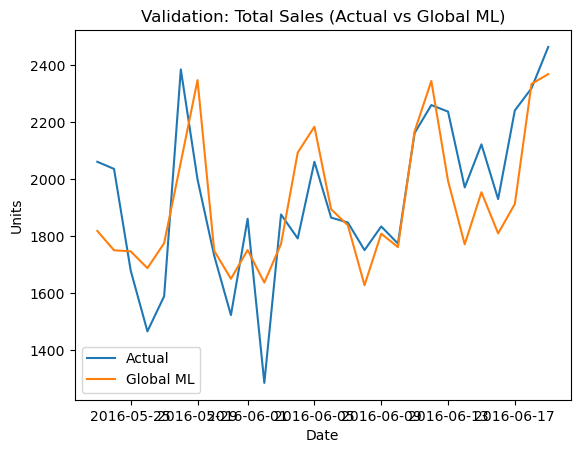

In [139]:
# Plot: total actual vs ML prediction on validation window
ml_eval = eval_m[['id','date','sales']].copy()
ml_eval['yhat'] = val_pred
ml_plot = ml_eval.groupby('date')[['sales','yhat']].sum().reset_index()

plt.figure()
plt.plot(ml_plot['date'], ml_plot['sales'], label='Actual')
plt.plot(ml_plot['date'], ml_plot['yhat'], label='Global ML')
plt.title('Validation: Total Sales (Actual vs Global ML)')
plt.xlabel('Date')
plt.ylabel('Units')
plt.legend()
plt.show()


## Generate 28-day forecasts

In [23]:
# Fit ML on all usable observed rows
full_train = model_df.copy()
X_full, y_full = full_train[feature_cols], full_train['sales']
ml.fit(X_full, y_full)

print('Fitted ML on:', X_full.shape)


Fitted ML on: (1597443, 13)


In [25]:
def recursive_ml_forecast(master: pd.DataFrame, model, start_date: pd.Timestamp, horizon=28, feature_cols=None):
    if feature_cols is None:
        raise ValueError("feature_cols required")

    work = master.sort_values(["id", "date"]).copy()
    work["pred_sales"] = work["sales"].astype(float)

    future_dates = pd.date_range(start=start_date, periods=horizon, freq="D")
    preds = []

    for d in future_dates:
        # IMPORTANT: avoid duplicate "sales" column
        temp = work.drop(columns=["sales"]).rename(columns={"pred_sales": "sales"})
        temp = add_lag_roll_features(temp)

        step = temp[temp["date"] == d].copy()
        if step.empty:
            raise ValueError(
                f"Missing rows for forecast date {d}. "
                "Ensure master has future calendar/price rows for that date."
            )

        X_step = step[feature_cols]
        yhat = model.predict(X_step)
        yhat = np.clip(yhat, 0, None)

        # write back predictions for that day
        pred_map = dict(zip(step["id"].values, yhat))
        mask = work["date"].eq(d)
        work.loc[mask, "pred_sales"] = work.loc[mask, "id"].map(pred_map).values

        preds.append(pd.DataFrame({"id": step["id"].values, "date": d, "yhat": yhat}))

    return pd.concat(preds, ignore_index=True)


In [26]:
# Because we don't have fature data for the 28 days of submission we create synthetic data


forecast_start = max_obs_date + pd.Timedelta(days=1)
future_dates = pd.date_range(forecast_start, periods=28, freq="D")

ids_cols = [c for c in df.columns if c in [
    "id","item_id","store_id","state_id","dept_id","cat_id"
]]
ids = df[ids_cols].drop_duplicates("id")

future = ids.merge(
    pd.DataFrame({"date": future_dates}),
    how="cross"
)

# Calendar features from date
future["weekday"] = future["date"].dt.weekday.astype("int8")
future["month"] = future["date"].dt.month.astype("int8")
future["weekofyear"] = future["date"].dt.isocalendar().week.astype("int16")

# No knowledge of future promos/events → set to neutral
future["is_event"] = 0
future["is_snap"] = 0

# Prices: carry last observed forward (best possible)
if "sell_price" in df.columns:
    last_price = (
        df.dropna(subset=["sell_price"])
          .sort_values("date")
          .groupby("id")["sell_price"]
          .last()
          .rename("sell_price")
          .reset_index()
    )
    future = future.merge(last_price, on="id", how="left")

future["sales"] = np.nan

# Combine history + future
df_for_fcst = (
    pd.concat([df, future], ignore_index=True)
      .sort_values(["id","date"])
      .reset_index(drop=True)
)

print("Future rows added:", future.shape)
print("Combined date range:", df_for_fcst["date"].min(), "→", df_for_fcst["date"].max())


Future rows added: (23044, 14)
Combined date range: 2011-01-29 00:00:00 → 2016-07-17 00:00:00


In [27]:
# Define forecast start = day after last observed sales date
forecast_start = max_obs_date + pd.Timedelta(days=1)
print('Forecast start:', forecast_start)

# Use the full df (history + any future rows in master) for recursive ML forecasting
ml_fcst = recursive_ml_forecast(
    df_for_fcst,
    ml,
    start_date=forecast_start,
    horizon=28,
    feature_cols=feature_cols
)

sn_fcst = seasonal_naive_7day_forecast(obs[['id','date','sales']], start_date=forecast_start, horizon=28)

print('ML forecast shape:', ml_fcst.shape)
print('SN forecast shape:', sn_fcst.shape)


Forecast start: 2016-06-20 00:00:00
ML forecast shape: (23044, 3)
SN forecast shape: (23044, 3)


## Build submission file 


In [29]:
# Choose which model to submit
MODEL_TO_SUBMIT = 'ml'  # 'ml' or 'seasonal_naive'

fcst = ml_fcst if MODEL_TO_SUBMIT == 'ml' else sn_fcst

# Pivot forecasts into wide format with columns F1..F28
fcst = fcst.sort_values(['id','date'])
fcst['h'] = fcst.groupby('id').cumcount() + 1
wide = fcst.pivot(index='id', columns='h', values='yhat')
wide.columns = [f'F{c}' for c in wide.columns]
wide = wide.reset_index()

# Join with sample submission template (keeps required row order and any extra ids)
sub = sample_sub[['id']].merge(wide, on='id', how='left')

# If some ids are missing (e.g., template contains evaluation ids not present in master), fill with 0
fcols = [c for c in sample_sub.columns if c.startswith('F')]
for c in fcols:
    if c not in sub.columns:
        sub[c] = 0.0
sub[fcols] = sub[fcols].fillna(0.0)

sub = sub[['id'] + fcols]
sub.head()


,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,FOODS_3_001_TX_3_validation,0.171472,0.270912,0.270912,0.270912,0.287754,0.486767,0.459205,0.436285,0.379338,...,0.348936,0.404996,0.438701,0.389041,0.332094,0.332094,0.332094,0.348936,0.404996,0.438701
1,FOODS_3_002_TX_3_validation,1.835161,1.698787,1.764318,1.515996,1.487147,1.653092,1.811389,1.572942,1.574740,...,1.872679,2.174531,2.306673,1.893623,1.727474,1.694280,1.601749,1.616333,1.925820,1.882934
2,FOODS_3_003_TX_3_validation,0.466878,0.412521,0.351254,0.440606,0.454858,0.465121,0.498826,0.496338,0.439391,...,0.612299,0.725004,0.758710,0.645194,0.588247,0.588247,0.588247,0.612299,0.725004,0.819977
3,FOODS_3_004_TX_3_validation,0.449094,0.451330,0.389558,0.304010,0.320851,0.365375,0.454431,0.389041,0.332094,...,0.365452,0.465121,0.514555,0.525958,0.469011,0.439391,0.392147,0.425505,0.481566,0.528411
4,FOODS_3_005_TX_3_validation,1.560792,1.551456,1.551456,1.355568,1.417463,1.686980,1.709247,1.398949,1.311949,...,1.304157,1.530073,1.633802,1.398949,1.311949,1.336691,1.206545,1.304157,1.530073,1.560242


In [30]:
# Save submission
out_path = f'./outputs/submission_{MODEL_TO_SUBMIT}.csv'
sub.to_csv(out_path, index=False)
print('Wrote:', out_path, ' shape:', sub.shape)


OSError: Cannot save file into a non-existent directory: 'outputs'

In [ ]:
def backtest_rmse(df, model, feature_cols, horizons=28, n_folds=3):
    rmses = []

    dates = sorted(df["date"].unique())
    for i in range(n_folds):
        cutoff = dates[-(horizons * (i + 2))]
        train = df[df["date"] <= cutoff]
        val_start = cutoff + pd.Timedelta(days=1)

        feat = add_lag_roll_features(train).dropna()
        X, y = feat[feature_cols], feat["sales"]

        model.fit(X, y)

        val = train[train["date"] >= val_start]
        yhat = model.predict(val[feature_cols])

        rmse = mean_squared_error(val["sales"], yhat, squared=False)
        rmses.append(rmse)

    return rmses